In [1]:

import pandas as pd
from glob import glob
import numpy as np
import math
import csv
import pandas as pd
from math import sqrt
from math import cos
from math import sin
import time
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as colors
def rad(d): #convert an angle in degrees (d) to radians
    return d * math.pi / 180.0

def getDistance(lat1, lng1, lat2, lng2): #great-circle distance (also known as the orthodromic distance) between two points on the Earth's surface,
    #given their latitude and longitude coordinates
    EARTH_REDIUS = 6378.137
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(math.sqrt(math.pow(sin(a / 2), 2) + cos(radLat1) * cos(radLat2) * math.pow(sin(b / 2), 2)))
    s = s * EARTH_REDIUS
    return s


def initPop():  # Initialize the population
    p1 = []
    for i in range(NUM_CHROME):
        p1.append(np.random.permutation(range(1 ,NUM_POINT+1)))
    return p1


#get as input some dictionaries that have available weight, unmet, and prev_inv of each population
#change globally
def fitFunc(x1, index_x1_in_p1, model, hour, dict_before_alteration_weight, dict_before_alteration_truck_location, dict_before_alteration_unmet,
            dict_before_alteration_pre_inv,dict_before_alteration_capacity,dict_before_alteration_carbon,dict_before_alteration_distance,dict_before_alteration_route, is_final_route, max_cities_allowed_for_truck, mod, case,scales_dict):
    vtotal = 0
    vcarbon = 0
    v_dist = np.zeros((NUM_VEHICLE,), dtype=float) #3 #distance travelled by truck
    v_carbon = np.zeros((NUM_VEHICLE,), dtype=float) #3 #distance travelled by truck
    pre_city = dict_before_alteration_truck_location[model][hour].copy()
    weight=dict_before_alteration_weight[model][hour].copy()
    truck_last_station = dict_before_alteration_truck_location[model][hour].copy()
    unmet=dict_before_alteration_unmet[model][hour].copy()
    prev_inv=dict_before_alteration_pre_inv[model][hour].copy()
    station_capacity=dict_before_alteration_capacity[model][hour].copy()
    route = np.zeros([NUM_VEHICLE, NUM_POINT], dtype=int) #3,20


    for i in range(NUM_POINT):  # Distribute the stations to each truck    #13
        station_row = snn.iloc[x1[i]-1:x1[i]][mod+'_inbound_minus_outbound'].to_list()
        if len(station_row)>0:
            if (station_row[0]!=0) and (np.sum([len(route[tr][(route[tr] != 0)]) for tr in range(NUM_VEHICLE)])<max_cities_allowed_for_truck*NUM_VEHICLE):
                #truck with the minimum great-circle distance to station i
                if 'kClosestStations' not in case:
                    if case in ['GA_predicted','GA_actual']:
                        if station_row[0]+prev_inv[x1[i] -1]<0:

                            opt = [((((np.abs(station_row[0]+prev_inv[x1[i] -1])-
                                               np.min([weight[k],station_capacity[x1[i] -1]-prev_inv[x1[i] -1],
                                                          np.abs(station_row[0]+
                                                                 prev_inv[x1[i] -1])]))))-scales_dict[mod.replace("rounded_", "")]['scaled_min_unmet'][NUM_VEHICLE-1])/(scales_dict[mod.replace("rounded_", "")]['scaled_max_unmet'][NUM_VEHICLE-1]-scales_dict[mod.replace("rounded_", "")]['scaled_min_unmet'][NUM_VEHICLE-1])
                                           + ((((dist[pre_city[k]][x1[i]])*((((1.1017 -0.7725)/MAX_WEIGHT)*weight[k])+0.7725)))-scales_dict[mod.replace("rounded_", "")]['scaled_min_carbon'][NUM_VEHICLE-1])/(scales_dict[mod.replace("rounded_", "")]['scaled_max_carbon'][NUM_VEHICLE-1]-scales_dict[mod.replace("rounded_", "")]['scaled_min_carbon'][NUM_VEHICLE-1])
                                           if (weight[k]!=0 and (len(route[k][(route[k] != 0)])<max_cities_allowed_for_truck)) else np.inf for k in range(NUM_VEHICLE) ]




                            if opt!=[np.inf for truck in range(NUM_VEHICLE)]:
                                j = np.argmin(opt)
                            else:
                                j=None

                        elif station_row[0]+prev_inv[x1[i] -1]>0:
                            opt=[((((np.abs(station_row[0]+prev_inv[x1[i] -1])-
                                               np.min([MAX_WEIGHT-weight[k],
                                                          np.abs(station_row[0]+
                                                                 prev_inv[x1[i] -1])]))))-scales_dict[mod.replace("rounded_", "")]['scaled_min_unmet'][NUM_VEHICLE-1])/(scales_dict[mod.replace("rounded_", "")]['scaled_max_unmet'][NUM_VEHICLE-1]-scales_dict[mod.replace("rounded_", "")]['scaled_min_unmet'][NUM_VEHICLE-1])
                                           + ((((dist[pre_city[k]][x1[i]])*((((1.1017 -0.7725)/MAX_WEIGHT)*weight[k])+0.7725)))-scales_dict[mod.replace("rounded_", "")]['scaled_min_carbon'][NUM_VEHICLE-1])/(scales_dict[mod.replace("rounded_", "")]['scaled_max_carbon'][NUM_VEHICLE-1]-scales_dict[mod.replace("rounded_", "")]['scaled_min_carbon'][NUM_VEHICLE-1])
                                           if ( MAX_WEIGHT != weight[k] and (len(route[k][(route[k] != 0)])<max_cities_allowed_for_truck)) else np.inf for k in range(NUM_VEHICLE) ]


                            if opt!=[np.inf for truck in range(NUM_VEHICLE)]:
                                j = np.argmin(opt)
                            else:
                                j=None
                    elif 'SortedDemandRandomTruck' in case:
                        opt = [1 if (len(route[k][(route[k] != 0)])<max_cities_allowed_for_truck) else np.inf for k in range(NUM_VEHICLE) ]
                        if opt!=[np.inf for truck in range(NUM_VEHICLE)]:
                            indices_with_one = [index for index, value in enumerate(opt) if value == 1]

                            # Randomly select an index from the list of indices with value 1
                            j = np.random.choice(indices_with_one)
                        else:
                            j=None
                    elif 'SortedDemandClosestTruck' in case:
                        opt = [(dist[pre_city[k]][x1[i]]) if (len(route[k][(route[k] != 0)])<max_cities_allowed_for_truck) else np.inf for k in range(NUM_VEHICLE) ]
                        if opt!=[np.inf for truck in range(NUM_VEHICLE)]:
                            j = np.argmin(opt)
                        else:
                            j=None


                    if (station_row[0]+prev_inv[x1[i] -1]!=0)and (j!=None):
                        v_dist[j] += dist[pre_city[j]][x1[i]]
                        v_carbon[j] += dist[pre_city[j]][x1[i]]*((((1.1017 -0.7725)/MAX_WEIGHT)*weight[j])+0.7725)
                        pre_city[j] = x1[i]

                        for a in range(NUM_POINT):      # Keep a record of the stations    #20
                            if route[j][a] == 0:  #if truck j has not yet travelled to station a
                                route[j][a] = x1[i]
                                break


    if 'kClosestStations' in case:
        count = 0
        cities_to_traverse = [x1[i] for i in range(NUM_POINT) if snn.iloc[x1[i]-1:x1[i]][mod+'_inbound_minus_outbound'].to_list()[0]!=0]
        # print(cities_to_traverse)
        while count<max_cities_allowed_for_truck*NUM_VEHICLE:
            for j in range(NUM_VEHICLE):
                if ((len(route[j][(route[j] != 0)])<max_cities_allowed_for_truck) and len(cities_to_traverse)>0):
                    # print('yes')
                    chosen_city_index = np.argmin([(dist[pre_city[j]][cityy]) for cityy in cities_to_traverse])
                    # print('chosen_city_index',chosen_city_index)
                    chosen_city = cities_to_traverse[chosen_city_index]
                    # print('chosen_city',chosen_city)
                    cities_to_traverse.remove(chosen_city)
                    count = count + 1
                    v_dist[j] += dist[pre_city[j]][chosen_city]
                    v_carbon[j] += dist[pre_city[j]][chosen_city]*((((1.1017 -0.7725)/MAX_WEIGHT)*weight[j])+0.7725)
                    pre_city[j] = chosen_city

                    for a in range(NUM_POINT):      # Keep a record of the stations    #20
                        if route[j][a] == 0:  #if truck j has not yet travelled to station a
                            route[j][a] = chosen_city
                            break

            if ((len(cities_to_traverse)==0) or (np.sum([len(route[tr][(route[tr] != 0)]) for tr in range(NUM_VEHICLE)])>=max_cities_allowed_for_truck*NUM_VEHICLE)):
                break


    for i in range(NUM_VEHICLE):
        for j in range(NUM_POINT):

            if route[i][j] != 0:
                station_row2=snn.iloc[route[i][j]-1:route[i][j]]
                pred_flow = station_row2[mod+'_inbound_minus_outbound'].to_list()[0]
                actual_flow = station_row2['actual_inbound_minus_outbound'].to_list()[0]
                if pred_flow + prev_inv[route[i][j] -1]<=0: #-1 is because in prev_inv indices start from 0 but city indices start from 1
                    if pred_flow + prev_inv[route[i][j] -1]<0:
                        what_given = np.min([weight[i],station_capacity[route[i][j] -1]-prev_inv[route[i][j] -1],
                                                np.abs(pred_flow+
                                                       prev_inv[route[i][j] -1])])
                        what_taken=0

                    elif pred_flow + prev_inv[route[i][j] -1]==0:
                        what_given = 0
                        what_taken=0
                    weight[i] = weight[i]-what_given
                else:
                    ###what we can take should be decided on capacity on truck, and the inventory on station, and that's it.
                    what_taken = np.min([MAX_WEIGHT-weight[i],
                                                   prev_inv[route[i][j] -1]])
                    what_given = 0
                    weight[i] = weight[i]+what_taken
                oo = prev_inv[route[i][j] -1] + what_given - what_taken + actual_flow
                prev_inv[route[i][j] -1] = np.max([np.min([oo,station_capacity[route[i][j] -1]]),0])
                unmet[route[i][j] -1] = -oo if oo<0 else 0

                #and we don't care about unmet supply.


    cities_covered_in_route = [route[i][j] for i in range(NUM_VEHICLE) for j in range(NUM_POINT) if route[i][j]!=0]
    cities_not_covered_in_route = [city for city in snn[snn[mod+'_inbound_minus_outbound']!=0]['station_index'].to_list() if city not  in cities_covered_in_route]
    for city in cities_not_covered_in_route:
        actual_flow = snn.iloc[city-1:city]['actual_inbound_minus_outbound'].to_list()[0]
        what_given = 0
        what_taken = 0

        oo = prev_inv[city -1] + what_given - what_taken + actual_flow
        prev_inv[city -1] = np.max([np.min([oo,station_capacity[city -1]]),0])
        unmet[city -1] = -oo if oo<0 else 0


    if (hour!=0) and (hour%10==0):
        for i in range(NUM_VEHICLE):
            v_dist[i] += dist[pre_city[i]][0]
            v_carbon[i] += dist[pre_city[i]][0]*((((1.1017 -0.7725)/MAX_WEIGHT)*weight[i])+0.7725)
            pre_city[i] = 0
    if is_final_route==True:
        dict_after_alteration_truck_location[model][hour+1]=pre_city
    for i in range(NUM_VEHICLE):  # Calculate the total distance
        vtotal += v_dist[i]
    for i in range(NUM_VEHICLE):  # Calculate the total distance
        vcarbon += v_carbon[i]

    total_unmet = np.sum(unmet)

    ###Should only do this if final route is found!
    if is_final_route==True:

        dict_after_alteration_weight[model][hour+1]=weight.copy()
        dict_after_alteration_pre_inv[model][hour+1]=prev_inv.copy()
        dict_after_alteration_unmet[model][hour+1]=unmet.copy()
        # if np.sum(dict_after_alteration_unmet[model][hour+1])!=np.sum(unmet):
        #     print('error in unmet')
        dict_after_alteration_carbon[model][hour+1]=v_carbon
        dict_after_alteration_distance[model][hour+1]=v_dist
        dict_after_alteration_route[model][hour+1]=route


    return [-(((vcarbon-scales_dict[mod.replace("rounded_", "")]['scaled_min_carbon'][NUM_VEHICLE-1])/(scales_dict[mod.replace("rounded_", "")]['scaled_max_carbon'][NUM_VEHICLE-1]-scales_dict[mod.replace("rounded_", "")]['scaled_min_carbon'][NUM_VEHICLE-1]))+((total_unmet-scales_dict[mod.replace("rounded_", "")]['scaled_min_unmet'][NUM_VEHICLE-1])/(scales_dict[mod.replace("rounded_", "")]['scaled_max_unmet'][NUM_VEHICLE-1]-scales_dict[mod.replace("rounded_", "")]['scaled_min_unmet'][NUM_VEHICLE-1]))), vtotal, vcarbon, total_unmet]  # Return the total path length


def evaluatePop(p1, model, hour, dict_before_alteration_weight,dict_before_alteration_truck_location, dict_before_alteration_unmet,
                dict_before_alteration_pre_inv,dict_before_alteration_capacity,dict_before_alteration_carbon,dict_before_alteration_distance, dict_before_alteration_route, is_final_route,max_cities_allowed_for_truck, mod, case, scales_dict):  # Evaluate the fitness of the population
    return [fitFunc(p1[i],i, model, hour, dict_before_alteration_weight,dict_before_alteration_truck_location,dict_before_alteration_unmet,
                    dict_before_alteration_pre_inv,dict_before_alteration_capacity,dict_before_alteration_carbon,dict_before_alteration_distance, dict_before_alteration_route, is_final_route,max_cities_allowed_for_truck, mod, case, scales_dict) for i in range(len(p1))]  #len(p1) = 20


def selection(p1, p_fit):  # Use binary tournament selection method to choose parents
    a1 = []

    for i in range(NUM_PARENT):
        [j, k] = np.random.choice(NUM_CHROME, 2, replace=False)  # Choose two indices at random
        if p_fit[j] > p_fit[k]:  # Select the best
            a1.append(p1[j].copy())
        else:
            a1.append(p1[k].copy())

    return a1


def crossover_uniform(p1):  # Use uniform crossover to reproduce offspring
    a1 = []

    for i in range(NUM_CROSSOVER):
        mask1 = np.random.randint(2, size=NUM_POINT)
        mask2 = np.random.randint(2, size=2 * NUM_VEHICLE)
        [j, k] = np.random.choice(NUM_PARENT, 2, replace=False)  # Choose two indices at random
        child1, child2 = p1[j].copy(), p1[k].copy()
        remain1, remain2 = list(p1[j].copy()), list(p1[k].copy())  # Save the cities (?) that have not been used yet
        for m in range(NUM_POINT):
            if mask1[m] == 1:
                remain2.remove(child1[m])  # Remove the value in remain2 that is equal to child1[m].
                remain1.remove(child2[m])  # Remove the value in remain1 that is equal to child2[m].


        t = 0
        for m in range(NUM_POINT):
            if mask1[m] == 0:
                child1[m] = remain2[t]
                child2[m] = remain1[t]
                t += 1


        a1.append(child1)
        a1.append(child2)



    return a1


def mutation(p1):  # Mutation
    for _ in range(NUM_MUTATION):
        row = np.random.randint(NUM_CROSSOVER_2)  # Select a chromosome at random
        if np.random.randint(2) == 0: #mutate a population's city
            if len(np.isin(offspring1[0],non_zero)[np.isin(offspring1[0],non_zero)==True])>=2:
                [j, k] = np.random.choice(np.array(np.where(np.isin(offspring1[0],non_zero)))[0],2,replace=False)  # Choose two genes at random

                p1[row][j], p1[row][k] = p1[row][k], p1[row][j]  # Swap two genes of this chromosome

def sortChrome(a1, a_fit_whole, a_fit, distance_fit, carbon_fit, unmet_fit):  # "Sort 'a' in descending order based on 'a_fit' "
    a_index = range(len(a1))  # Generate a list of 0, 1, 2, ..., |a|-1
    a_fit, a_index = zip(*sorted(zip(a_fit, a_index), reverse=True))  # Sort a_index in descending order based on a_fit with corresponding linkage
    return [a1[i] for i in a_index], [list(a_fit_whole[i]) for i in a_index] ,a_fit, [distance_fit[i] for i in a_index], [carbon_fit[i] for i in a_index],[unmet_fit[i] for i in a_index]# Return 'a' in the order of a_index and return the corresponding fitness values


def replace(p1, p_fit_whole, p_fit, a1, a_fit_whole, a_fit, case):
    if case in ['GA_predicted','GA_actual']:
        b1 = np.concatenate((p1, a1), axis=0)  # Combine the current generation p with the offspring a to create b
        b_fit = p_fit + a_fit  # Combine the fitness values of the two generations into b_fit.
        whole_=list(p_fit_whole)+list(a_fit_whole)
        distance_fit = [p_fit_whole[u][1] for u in range(len(p_fit_whole))] + [a_fit_whole[u][1] for u in range(len(a_fit_whole))]
        carbon_fit = [p_fit_whole[u][2] for u in range(len(p_fit_whole))] + [a_fit_whole[u][2] for u in range(len(a_fit_whole))]
        unmet_fit = [p_fit_whole[u][3] for u in range(len(p_fit_whole))] + [a_fit_whole[u][3] for u in range(len(a_fit_whole))]
    else:
        b1=p1
        b_fit=p_fit
        whole_=p_fit_whole
        distance_fit = [p_fit_whole[u][1] for u in range(len(p_fit_whole))]
        carbon_fit = [p_fit_whole[u][2] for u in range(len(p_fit_whole))]
        unmet_fit = [p_fit_whole[u][3] for u in range(len(p_fit_whole))]
    b1, whole_,b_fit, distance_fit, carbon_fit, unmet_fit = sortChrome(b1, whole_, b_fit, distance_fit, carbon_fit, unmet_fit)  # Sort b and b_fit in a linked manner

    return b1[:NUM_CHROME], list(whole_[:NUM_CHROME]) ,list(b_fit[:NUM_CHROME]),list(distance_fit[:NUM_CHROME]),list(carbon_fit[:NUM_CHROME]),list(unmet_fit[:NUM_CHROME])  # Return NUM_CHROME individuals for a new generation


class kv_pair(dict):
    def __init__(self):
        self = dict()
    def add(self, key, value):
        self[key] = value


def two_level_dict(main_dict, list_cols):
    rows = []
    for outer_key, inner_dict in main_dict.items():
        for key, value in inner_dict.items():
            if isinstance(value, list):
                for item in value:
                    rows.append({'outer_key': outer_key, 'key': key, 'value': item})
            else:
                rows.append({'outer_key': outer_key, 'key': key, 'value': value})

    df_ =pd.DataFrame(rows)
    for i in range(len(list_cols)):
        df_[list_cols[i][0]]=list_cols[i][1]
    return df_


def three_level_dict(main_dict, list_cols):
    rows = []
    for outer_key, mid_dict in main_dict.items():
        for mid_key, inner_dict in mid_dict.items():
            for key, value in inner_dict.items():
                if isinstance(value, list):
                    for item in value:
                        rows.append({'outer_key': outer_key, 'mid_key': mid_key, 'key': key, 'value': item})
                else:
                    rows.append({'outer_key': outer_key, 'mid_key': mid_key, 'key': key, 'value': value})

    # Convert to DataFrame
    df_ =pd.DataFrame(rows)
    for i in range(len(list_cols)):
        df_[list_cols[i][0]]=list_cols[i][1]
    return df_


In [ ]:


np.random.seed(0)
data1 = pd.read_csv("Par_station_needs1.csv")
data1.sort_values(['hour','station_index'],ascending=True).reset_index(drop=True)
loc1 = pd.read_csv("Par_station_capacity1.csv")
depot_lon = np.random.uniform(-79.44, -79.36)  #chosen based on 5 and 95th quantile of stations' lon
depot_lat = np.random.uniform(43.63, 43.67)  #chosen based on 5 and 95th quantile of stations' lat
station_capacity1=loc1['capacity'].to_list()
loc1=pd.concat([pd.DataFrame([[0,'depot','depot',depot_lat,depot_lon,'-']],columns=loc1.columns),loc1])
loc1 = loc1.reset_index(drop=True)
lat = loc1["lat"]
lat = np.array(lat)
lon = loc1["lon"]
lon = np.array(lon)
location = loc1[["lat", "lon"]]
location = np.array(location)
NUM_CITY = len(loc1)-1
NUM_POINT = NUM_CITY   #Default maximum route length.

c = (NUM_CITY + 1, NUM_CITY + 1)
dist = np.zeros(c, dtype=float)

for aa in range(NUM_CITY + 1):
    for bb in range(NUM_CITY + 1):
        dist[aa][bb] = getDistance(lat[aa], lon[aa], lat[bb], lon[bb])

NUM_CHROME = NUM_CITY  # Number of chromosomes

NUM_PARENT = NUM_CHROME  # Number of parents
max_cities_allowed_for_truck = 10
NUM_ITERATION = 50
Total_initial_bikes = 60
MAX_WEIGHT = 30  # Maximum load capacity
scales_dict = {'predicted':{'scaled_min_unmet' : [0.0, 0.0, 0.0, 0.0, 0.0],
'scaled_max_unmet' :[54.0, 52.0, 49.0, 46.0, 43.0],
'scaled_min_carbon' :[2.231383394835604, 2.253007557790094, 2.056672547742034, 2.056200664313795, 1.874661968699276],
'scaled_max_carbon' :[43.78183229862017, 77.8873602709108, 99.76997927122393, 120.75658432155184, 138.80474022139836]},
               'actual':{'scaled_min_unmet' : [0.0, 0.0, 0.0, 0.0, 0.0],
'scaled_max_unmet' : [82.0, 70.0, 60.0, 52.0, 47.0],
'scaled_min_carbon' : [7.572065210088888, 7.344529989471393, 6.765360512177194, 6.391161668027737, 6.140708404777159],
'scaled_max_carbon' : [41.403050197627316, 74.34327132334276, 95.57248368919491, 116.06921910856009, 136.5484523684718]}}

df_1=pd.DataFrame()
df_2=pd.DataFrame()
df_3=pd.DataFrame()

cases = ['GA_actual','GA_predicted','noGA_predicted_SortedDemandRandomTruck','noGA_predicted_kClosestStations','noGA_predicted_SortedDemandClosestTruck',
        'noGA_actual_SortedDemandRandomTruck','noGA_actual_kClosestStations','noGA_actual_SortedDemandClosestTruck']
crossmute = [(0.8,0.1)]
NUM_VEHICLE_list = [2]
# models_list = ['LSTM', 'GRU']
models_list = ['LSTM']

In [ ]:

for case in cases:
    print('case: ',case)
    if 'predicted' in case:
        mod = 'rounded_predicted'
        mod1 = 'predicted'
    elif 'actual' in case:
        mod = 'actual'
        mod1 = 'actual'
    if case in ['GA_predicted','GA_actual']:
        subs = len(crossmute)
    else:
        subs = 1
    for NUM_VEHICLE in NUM_VEHICLE_list:
        print('NUM_VEHICLE: ',NUM_VEHICLE)
        INIT_WEIGHT = int(Total_initial_bikes/NUM_VEHICLE)   # Initial load capacity
        for sub in range(subs):
            Pc, Pm = crossmute[sub]
            print('Pc, PM: ',Pc, Pm)
            NUM_CROSSOVER = int(Pc * NUM_CHROME / 2)  # Number of crossover times
            NUM_CROSSOVER_2 = NUM_CROSSOVER * 2  # Double the number above
            NUM_MUTATION = int(Pm * NUM_CHROME * NUM_POINT)  # Number of mutation times
            dict_model_hour=kv_pair()
            dict_model_aggregate_results=kv_pair()
            dict_model_hour_fitness_per_run=kv_pair()
            for model_ in models_list:
                print('model: ',model_)
                dict_hour=kv_pair()
                dict_hour_fitness_per_run=kv_pair()
                seed_ = 0
                time_init=time.time()
                for hour in range(1,int(data1['hour'].max())+1):
                    print('hour: ',hour)

                    seed_ = seed_ + 1
                    np.random.seed(seed_)
                    is_final_route = False
                    df_hour = data1[(data1['model']==model_)&(data1['hour']==hour)]
                    if mod =='actual':
                        snn=df_hour[['station_index','actual_inbound_minus_outbound']].reset_index(drop=True)
                    elif mod=='rounded_predicted':
                        snn=df_hour[['station_index','actual_inbound_minus_outbound','rounded_predicted_inbound_minus_outbound']].reset_index(drop=True)

                    non_zero=snn[snn[mod+'_inbound_minus_outbound']!=0]['station_index'].to_list()

                    if hour==1:
                        dict_before_alteration_weight = {model_:dict(zip(
                            [hour for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)], [np.full((NUM_VEHICLE,), INIT_WEIGHT)
                                                                                                              for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)]))
                                                                                    } #[15,15,15])
                        dict_before_alteration_truck_location = {model_:dict(zip(
                            [hour for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)], [np.zeros(NUM_VEHICLE, dtype=int)
                                                                                                              for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)]))}



                        dict_before_alteration_unmet = {model_:dict(zip(
                            [hour for hour in np.arange(1,data1[(data1['model']==model_)]['hour'].max()+1)], [np.zeros((NUM_CITY))
                                                                                                              for hour in np.arange(1,data1[(data1['model']==model_)]['hour'].max()+1)]))
                                                                                    } #[15,15,15])

                        dict_before_alteration_pre_inv = {model_:dict(zip(
                            [hour for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)], [np.zeros((NUM_CITY))
                                                                                                              for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)]))
                                                                                    } #[15,15,15])

                        dict_before_alteration_capacity = {model_:dict(zip(
                            [hour for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)], [station_capacity1
                                                                                                              for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)]))
                                                                                    } #[15,15,15])

                        dict_before_alteration_carbon = {model_:dict(zip(
                            [hour for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)], [np.zeros((1))
                                                                                                              for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)]))
                                                                                    } #[15,15,15])
                        dict_before_alteration_distance = {model_:dict(zip(
                            [hour for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)], [np.zeros((1))
                                                                                                              for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)]))
                                                                                    } #[15,15,15])

                        dict_before_alteration_route = {model_:dict(zip(
                            [hour for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)], [np.zeros([NUM_VEHICLE, NUM_POINT], dtype=int)
                                                                                                              for hour in np.arange(0,data1[(data1['model']==model_)]['hour'].max()+1)]))}

                        dict_after_alteration_weight=dict_before_alteration_weight.copy()
                        dict_after_alteration_truck_location=dict_before_alteration_truck_location.copy()
                        dict_after_alteration_unmet=dict_before_alteration_unmet.copy()
                        dict_after_alteration_pre_inv=dict_before_alteration_pre_inv.copy()
                        dict_after_alteration_capacity=dict_before_alteration_capacity.copy()   #this one never chnages.
                        dict_after_alteration_carbon=dict_before_alteration_carbon.copy()
                        dict_after_alteration_distance=dict_before_alteration_distance.copy()
                        dict_after_alteration_route=dict_before_alteration_route.copy()


                    else:
                        dict_before_alteration_weight=dict_after_alteration_weight.copy()
                        dict_before_alteration_truck_location=dict_after_alteration_truck_location.copy()
                        dict_before_alteration_unmet=dict_after_alteration_unmet.copy()
                        dict_before_alteration_pre_inv=dict_after_alteration_pre_inv.copy()
                        dict_before_alteration_capacity=dict_after_alteration_capacity.copy()
                        dict_before_alteration_carbon=dict_after_alteration_carbon.copy()
                        dict_before_alteration_distance=dict_after_alteration_distance.copy()
                        dict_before_alteration_route=dict_after_alteration_route.copy()

                    if case in ['GA_predicted','GA_actual']:
                        pop1= initPop()
                    else:
                        pop1= [np.array(snn.sort_values(by=mod+'_inbound_minus_outbound', key=abs, ascending=False)['station_index'].to_list())]
                    pop_fit = evaluatePop(pop1, model_, hour,
                                              dict_before_alteration_weight,dict_before_alteration_truck_location,dict_before_alteration_unmet,dict_before_alteration_pre_inv,
                                              dict_before_alteration_capacity,dict_before_alteration_carbon,dict_before_alteration_distance,dict_before_alteration_route, is_final_route, max_cities_allowed_for_truck, mod, case, scales_dict)
                    best_outputs = []
                    best_outputs.append(np.max([pop_fit[u][0] for u in range(len(pop_fit))]))

                    mean_outputs = []
                    mean_outputs.append(np.average([pop_fit[u][0] for u in range(len(pop_fit))]))
                    dict_fitness_per_run=kv_pair()
                    if case in ['GA_predicted','GA_actual']:
                        for i in range(NUM_ITERATION):
                            if i%100==0:
                                print('iteration: ',i)
                            seed_ = seed_ +1
                            np.random.seed(seed_)
                            parent1 = selection(pop1, [pop_fit[u][0] for u in range(len(pop_fit))] )
                            offspring1 = crossover_uniform(parent1)
                            mutation(offspring1)
                            offspring_fit= evaluatePop(offspring1,model_, hour, dict_before_alteration_weight,dict_before_alteration_truck_location,dict_before_alteration_unmet,
                                                       dict_before_alteration_pre_inv,dict_before_alteration_capacity,dict_before_alteration_carbon,dict_before_alteration_distance,dict_before_alteration_route, is_final_route,max_cities_allowed_for_truck, mod, case, scales_dict)

                            pop1, pop_fit, all_obj_fit, distance_fit, carbon_fit, unmet_fit = replace(pop1, pop_fit, [pop_fit[u][0] for u in range(len(pop_fit))], offspring1, offspring_fit, [offspring_fit[u][0] for u in range(len(offspring_fit))],case)

                            best_outputs.append(np.max(all_obj_fit))
                            mean_outputs.append(np.average(all_obj_fit))

                            dict_fitness_per_run.add(i, -[pop_fit[u][0] for u in range(len(pop_fit))][0])

                    else:
                        pop1, pop_fit, all_obj_fit, distance_fit, carbon_fit, unmet_fit = replace(pop1, pop_fit, [pop_fit[u][0] for u in range(len(pop_fit))], pop1, pop_fit, [pop_fit[u][0] for u in range(len(pop_fit))],case)
                        best_outputs.append(np.max(all_obj_fit))
                        mean_outputs.append(np.average(all_obj_fit))
                        dict_fitness_per_run.add(0, -[pop_fit[u][0] for u in range(len(pop_fit))][0])


                    dict_hour_fitness_per_run.add(hour, dict_fitness_per_run.copy())
                    is_final_route=True
                    _ = fitFunc(pop1[0],0, model_, hour, dict_before_alteration_weight,dict_before_alteration_truck_location,dict_before_alteration_unmet,
                                dict_before_alteration_pre_inv,dict_before_alteration_capacity,dict_before_alteration_carbon,dict_before_alteration_distance,dict_before_alteration_route, is_final_route, max_cities_allowed_for_truck, mod, case, scales_dict)
                    dict_hour.add(hour,{'best fitness':-[pop_fit[u][0] for u in range(len(pop_fit))][0],'mean_best_outputs':np.average(best_outputs),'mean_mean_outputs':np.average(mean_outputs),
                                               'best_outputs':best_outputs.copy(),'mean_outputs':mean_outputs.copy(),'best pop': pop1[0],
                                          'Total distance traveled by the vehicles':[pop_fit[u][1] for u in range(len(pop_fit))][0],
                                         'Total carbon emitted by the vehicles':[pop_fit[u][2] for u in range(len(pop_fit))][0],
                                         'Total unmet demand over all vehicles':[pop_fit[u][3] for u in range(len(pop_fit))][0],'route found':dict_after_alteration_route[model_][hour+1].copy(),
                                       'stations with non-zero demand':np.array(non_zero.copy()),
                                        '#stations with non-zero demand':len(non_zero),'#stations visited by trucks':np.count_nonzero(dict_after_alteration_route[model_][hour+1])})



                time_final=time.time()
                dict_model_hour.add(model_, dict_hour.copy())
                dict_model_hour_fitness_per_run.add(model_, dict_hour_fitness_per_run.copy())
                dict_model_aggregate_results.add(model_,{
                    'total distance travelled':np.sum([dict_model_hour[model_][hh]['Total distance traveled by the vehicles'] for hh in dict_model_hour[model_]]),
                                                        'total carbon emitted':np.sum([dict_model_hour[model_][hh]['Total carbon emitted by the vehicles'] for hh in dict_model_hour[model_]]),
                                                        'total unmet demand':np.sum([dict_model_hour[model_][hh]['Total unmet demand over all vehicles'] for hh in dict_model_hour[model_]]),
                    'mean distance travelled':np.mean([dict_model_hour[model_][hh]['Total distance traveled by the vehicles'] for hh in dict_model_hour[model_]]),
                                                        'mean carbon emitted':np.mean([dict_model_hour[model_][hh]['Total carbon emitted by the vehicles'] for hh in dict_model_hour[model_]]),
                                                        'mean unmet demand':np.mean([dict_model_hour[model_][hh]['Total unmet demand over all vehicles'] for hh in dict_model_hour[model_]]),
                    'std distance travelled':np.std([dict_model_hour[model_][hh]['Total distance traveled by the vehicles'] for hh in dict_model_hour[model_]]),
                                                        'std carbon emitted':np.std([dict_model_hour[model_][hh]['Total carbon emitted by the vehicles'] for hh in dict_model_hour[model_]]),
                                                        'std unmet demand':np.std([dict_model_hour[model_][hh]['Total unmet demand over all vehicles'] for hh in dict_model_hour[model_]]),
                    'total fitness':np.sum([dict_model_hour[model_][hh]['best fitness'] for hh in dict_model_hour[model_]]),
                                                        'mean fitness':np.mean([dict_model_hour[model_][hh]['best fitness'] for hh in dict_model_hour[model_]]),
                                                        'std fitness':np.std([dict_model_hour[model_][hh]['best fitness'] for hh in dict_model_hour[model_]]),
                    'time to run': time_final - time_init
                                                        })
            df_1=pd.concat([df_1, three_level_dict(dict_model_hour.copy(),[('Pm',Pm),('Pc',Pc),('Case',case), ('Num_vehicle',NUM_VEHICLE)])])
            df_2=pd.concat([df_2, three_level_dict(dict_model_hour_fitness_per_run.copy(),[('Pm',Pm),('Pc',Pc),('Case',case), ('Num_vehicle',NUM_VEHICLE)])])
            df_3=pd.concat([df_3, two_level_dict(dict_model_aggregate_results.copy(),[('Pm',Pm),('Pc',Pc),('Case',case), ('Num_vehicle',NUM_VEHICLE)])])

            df_1.to_csv('./results_GA/backup3//df_1_case_'+case+'_'+str(NUM_VEHICLE)+'_trucks_'+'Pc_'+str(Pc)+'_Pm_'+str(Pm)+'.csv')
            df_2.to_csv('./results_GA/backup3/df_2_case_'+case+'_'+str(NUM_VEHICLE)+'_trucks_'+'Pc_'+str(Pc)+'_Pm_'+str(Pm)+'.csv')
            df_3.to_csv('./results_GA/backup3/df_3_case_'+case+'_'+str(NUM_VEHICLE)+'_trucks_'+'Pc_'+str(Pc)+'_Pm_'+str(Pm)+'.csv')


In [2]:

# Define the directory path
directory_path = './new_results'  


# List all files in the directory and filter for CSV files
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

class kv_pair(dict):
    def __init__(self):
        self = dict()
    def add(self, key, value):
        self[key] = value


In [3]:
dict_ = kv_pair()
for trucks in [1, 2,3,4, 5]:
    for Pc in [0.2, 0.4, 0.6, 0.8]:
        for Pm in [0.01,0.05,0.1,0.2]:
            for thresh_stat in [1, 3, 5, 10, 20]:
                for wu in [0.25, 0.4, 0.5, 0.6, 0.75]:
                    for wc in [0.25, 0.4, 0.5, 0.6, 0.75]:
                        df_1=pd.DataFrame()
                        df_2=pd.DataFrame()
                        df_3=pd.DataFrame()

                        for a_1 in ['df_2_case_noGA_actual_SortedDemandClosestTruck_'+str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'.csv',
                                    ]:            
                            if a_1 in csv_files:
                                df_2=pd.concat([df_2, pd.read_csv('./new_results/'+a_1)])

                        for b_1 in [ 'df_3_case_noGA_actual_SortedDemandClosestTruck_'+str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'.csv',
                                    ]:               
                            if b_1 in csv_files:
                                df_3=pd.concat([df_3, pd.read_csv('./new_results/'+b_1)])

                        for c_1 in [ 'df_1_case_noGA_actual_SortedDemandClosestTruck_'+str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'.csv',
                                    ]:            
                            if c_1 in csv_files:
                                df_1=pd.concat([df_1, pd.read_csv('./new_results/'+c_1)])
                
                        if len(df_1)!=0:
                            dict_.add(str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'_df_1',df_1)
                        if len(df_2)!=0:
                            dict_.add(str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'_df_2',df_2)
                        if len(df_3)!=0:
                            dict_.add(str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'_df_3',df_3)

In [4]:
whole_df = pd.DataFrame()
for model in ['LSTM']:
    for trucks in [1, 2,3,4, 5]:
        for Pc in [0.2, 0.4, 0.6, 0.8]:
            for Pm in [0.01,0.05,0.1,0.2]:
                for thresh_stat in [1, 3, 5, 10, 20]:
                    for wu in [0.25, 0.4, 0.5, 0.6, 0.75]:
                        for wc in [0.25, 0.4, 0.5, 0.6, 0.75]:
                            if str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'_df_3' in dict_:
                                temp_df=dict_[str(trucks)+'_trucks_Pc_'+str(Pc)+'_Pm_'+str(Pm)+'_thresh_stat_'+str(thresh_stat)+'_wu_'+str(wu)+'_wc_'+str(wc)+'_df_3']
                                for variable in ['fitness','unmet demand','carbon emitted']:
                                    for algo in ['GA_predicted','GA_actual', 'noGA_predicted_SortedDemandRandomTruck','noGA_actual_SortedDemandRandomTruck',
                                                 'noGA_predicted_kClosestStations','noGA_actual_kClosestStations','noGA_predicted_SortedDemandClosestTruck',
                                'noGA_actual_SortedDemandClosestTruck']:
                    
                        
                                        temp_df2=temp_df[(temp_df['outer_key']==model)&(temp_df['key'].isin([i + variable for i in ['mean ','std ']]))&(temp_df['Case']==algo)]
                                        mean = temp_df2[temp_df2['key']=='mean '+variable]['value'].to_list()[0]
                                        std = temp_df2[temp_df2['key']=='std '+variable]['value'].to_list()[0]
                                        meanstd = str(np.round(mean,2)) + ' ('+str(np.round(std,2))+')'
                                        whole_df = pd.concat([whole_df,pd.DataFrame([[model,trucks, Pc,Pm,thresh_stat, wu, wc, variable, algo, mean, std, meanstd]],columns=['model','truck','Pc','Pm','thresh_stat','wu','wc','Variable','Algorithm','Value (mean)','Value (std)','Value (mean&std)'])])
                                        

In [5]:
import scipy
from scipy.stats import ranksums
df_p=pd.DataFrame()
m_ = dict_[str(2)+'_trucks_Pc_'+str(0.8)+'_Pm_'+str(0.01)+'_thresh_stat_'+str(1)+'_wu_'+str(0.5)+'_wc_'+str(0.5)+'_df_1']
for c in ['predicted','actual']:
    a = m_[(m_['key']=='Total carbon emitted by the vehicles')&(m_['Case']=='GA_'+c)]['value'].astype('float').to_list()
    
    for d in ['SortedDemandRandomTruck','kClosestStations','SortedDemandClosestTruck']:
        b = m_[(m_['key']=='Total carbon emitted by the vehicles')&(m_['Case']=='noGA_'+c+'_'+d)]['value'].astype('float').to_list()
        
        # df_p=pd.concat([df_p,pd.DataFrame([[c,d,np.round(scipy.stats.ranksums(a, b)[0],2),scipy.stats.ranksums(a, b)[1],np.round(scipy.stats.ttest_ind(a, b)[0],2),scipy.stats.ttest_ind(a, b)[1]]],columns=['main','secondary','ranksums','pranksums','ttest','pttest'])])
        df_p=pd.concat([df_p,pd.DataFrame([[c,d,np.round(scipy.stats.ranksums(a, b)[0],2),scipy.stats.ranksums(a, b)[1],np.round(scipy.stats.ttest_ind(a, b)[0],2),scipy.stats.ttest_ind(a, b)[1]]],columns=['main','secondary','ranksums','pranksums','ttest','pttest'])])

df_p['pranksums']=df_p['pranksums'].apply(lambda x: '<0.0001' if x<0.0001 else x)
df_p['pttest']=df_p['pttest'].apply(lambda x: '<0.0001' if x<0.0001 else x)

def parantheses_col(x,col1,col2):
    return str(x[col1])+' ('+str(x[col2])+')'
df_p['statpranksums']=df_p.apply(parantheses_col,args=('ranksums','pranksums',),axis=1)
df_p['statpttest']=df_p.apply(parantheses_col,args=('ttest','pttest',),axis=1)
# df_p.to_csv('./plots/groupcomparison.csv',index=False)


In [6]:
df_p

,main,secondary,ranksums,pranksums,ttest,pttest,statpranksums,statpttest
0,predicted,SortedDemandRandomTruck,-28.39,<0.0001,-43.82,<0.0001,-28.39 (<0.0001),-43.82 (<0.0001)
0,predicted,kClosestStations,-22.55,<0.0001,-24.95,<0.0001,-22.55 (<0.0001),-24.95 (<0.0001)
0,predicted,SortedDemandClosestTruck,-27.39,<0.0001,-42.26,<0.0001,-27.39 (<0.0001),-42.26 (<0.0001)
0,actual,SortedDemandRandomTruck,-29.57,<0.0001,-49.07,<0.0001,-29.57 (<0.0001),-49.07 (<0.0001)
0,actual,kClosestStations,-10.52,<0.0001,-11.76,<0.0001,-10.52 (<0.0001),-11.76 (<0.0001)
0,actual,SortedDemandClosestTruck,-28.27,<0.0001,-45.46,<0.0001,-28.27 (<0.0001),-45.46 (<0.0001)


In [7]:
def cal_alg_number(x):
    a=x['Algorithm']
    dict_={'GA_predicted':1,'GA_actual':2, 'noGA_predicted_SortedDemandRandomTruck':3,'noGA_actual_SortedDemandRandomTruck':4,
                             'noGA_predicted_kClosestStations':7,'noGA_actual_kClosestStations':8,'noGA_predicted_SortedDemandClosestTruck':5,
            'noGA_actual_SortedDemandClosestTruck':6}
    return dict_[a]
whole_df['alg_number']=whole_df.apply(cal_alg_number,axis=1)
# whole_df[whole_df['Variable']=='fitness'].sort_values(['alg_number','Pc','truck'])[['Algorithm','Pc', 'Pm','truck','Value (mean&std)']].to_csv('./plots/results_analysis1.csv',index=False)

In [8]:
df_1 = whole_df[(whole_df['truck']==2)&(whole_df['wu']==0.5)&(whole_df['thresh_stat']==1)&(whole_df['Variable']=='fitness')].sort_values(['alg_number','Pc','Pm','truck'],ascending=(True, True,False, True))
df_1

,model,truck,Pc,Pm,thresh_stat,wu,wc,Variable,Algorithm,Value (mean),Value (std),Value (mean&std),alg_number
0,LSTM,2,0.2,0.20,1,0.5,0.5,fitness,GA_predicted,0.070038,0.079746,0.07 (0.08),1
0,LSTM,2,0.2,0.10,1,0.5,0.5,fitness,GA_predicted,0.069078,0.078681,0.07 (0.08),1
0,LSTM,2,0.2,0.05,1,0.5,0.5,fitness,GA_predicted,0.067375,0.077777,0.07 (0.08),1
0,LSTM,2,0.2,0.01,1,0.5,0.5,fitness,GA_predicted,0.063422,0.071789,0.06 (0.07),1
0,LSTM,2,0.4,0.20,1,0.5,0.5,fitness,GA_predicted,0.066374,0.076030,0.07 (0.08),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,LSTM,2,0.6,0.01,1,0.5,0.5,fitness,noGA_actual_kClosestStations,0.051668,0.047193,0.05 (0.05),8
0,LSTM,2,0.8,0.20,1,0.5,0.5,fitness,noGA_actual_kClosestStations,0.051668,0.047193,0.05 (0.05),8
0,LSTM,2,0.8,0.10,1,0.5,0.5,fitness,noGA_actual_kClosestStations,0.051668,0.047193,0.05 (0.05),8
0,LSTM,2,0.8,0.05,1,0.5,0.5,fitness,noGA_actual_kClosestStations,0.051668,0.047193,0.05 (0.05),8


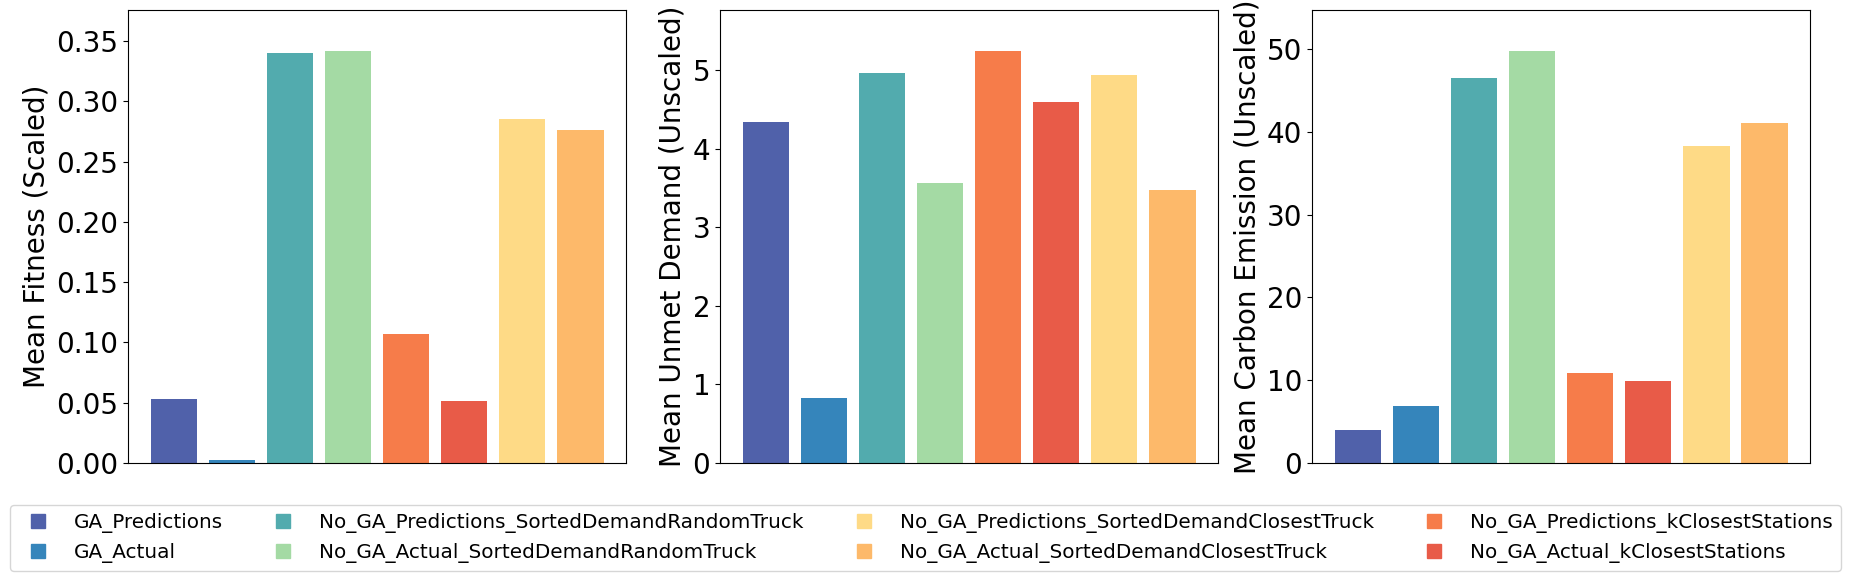

In [9]:
b = whole_df[(whole_df['Pc']==0.8)&(whole_df['Pm']==0.01)&(whole_df['truck']==2)&(whole_df['wu']==0.5)&(whole_df['thresh_stat']==1)].sort_values(['alg_number','Pc','truck'])[['Algorithm','Variable','Value (mean)']]
# b.to_csv('./plots/results_analysis2.csv',index=False)
import matplotlib.pyplot as plt
import seaborn as sns
data = b

# Separate the data by each variable
fitness_data = data[data['Variable'] == 'fitness']
unmet_demand_data = data[data['Variable'] == 'unmet demand']
carbon_emitted_data = data[data['Variable'] == 'carbon emitted']

unique_algorithms = data['Algorithm'].unique()
algorithm_mapping = {'GA_predicted':'GA_Predictions','GA_actual':'GA_Actual', 'noGA_predicted_SortedDemandRandomTruck': 'No_GA_Predictions_SortedDemandRandomTruck', 'noGA_actual_SortedDemandRandomTruck':'No_GA_Actual_SortedDemandRandomTruck',
                             'noGA_predicted_kClosestStations':'No_GA_Predictions_kClosestStations','noGA_actual_kClosestStations':'No_GA_Actual_kClosestStations','noGA_predicted_SortedDemandClosestTruck':'No_GA_Predictions_SortedDemandClosestTruck',
            'noGA_actual_SortedDemandClosestTruck':'No_GA_Actual_SortedDemandClosestTruck'}


num_colors = len(data['Algorithm'].unique())
# Assign a color to each algorithm from the 'Spectral_r' palette

palette = sns.color_palette("Spectral_r", 30)
# 
palette_colors = [palette[0], palette[2], palette[4], palette[8], palette[18], palette[20], palette[23], palette[25], palette[29]]


color_dict = {algorithm_mapping[alg]: palette_colors[i] for i, alg in enumerate(unique_algorithms)}


# Define a function to create a bar plot with colored bars
def create_colorful_bar_plot(dataset, title, ax, color_dict,ylabel,algorithm_mapping):
    # algorithms = dataset['Algorithm'].unique()
    algorithms=list(algorithm_mapping.keys())
    for i, algorithm in enumerate(algorithms):
        mapped_name = algorithm_mapping[algorithm]
        ax.bar(mapped_name, dataset.loc[dataset['Algorithm'] == algorithm, 'Value (mean)'].values[0], 
               color=color_dict[mapped_name])
    
    
    # ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xticks([])
    ax.set_ylim(0, max(dataset['Value (mean)']) * 1.1)
    ax.tick_params(axis='y', labelsize=20)

# Create a figure with one row and three columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Define font sizes
legend_fontsize = 'x-large'
title_fontsize = 'x-large'
ylabel_fontsize = 'large'
yticks_fontsize = 'medium'

# Plot each bar plot
create_colorful_bar_plot(fitness_data, 'Fitness', axes[0], color_dict,'Mean Fitness (Scaled)',algorithm_mapping)
create_colorful_bar_plot(unmet_demand_data, 'Unmet Demand', axes[1], color_dict,'Mean Unmet Demand (Unscaled)',algorithm_mapping)
create_colorful_bar_plot(carbon_emitted_data, 'Carbon Emitted', axes[2], color_dict,'Mean Carbon Emission (Unscaled)',algorithm_mapping)

# Create the legend with increased font size and place it horizontally below the plots
patches_mapped = [plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=color_dict[alg], 
                          label=alg)[0] for alg in color_dict.keys()]
fig.legend(handles=patches_mapped, bbox_to_anchor=(0.5, 0), loc='upper center', fontsize=legend_fontsize, ncol=4)

# Adjust layout to prevent overlapping
fig.tight_layout()

# # Save the figure with horizontal legend below the plots

plt.savefig('./plots/plots_analysis_2_fitness.png', dpi=100, bbox_inches='tight')


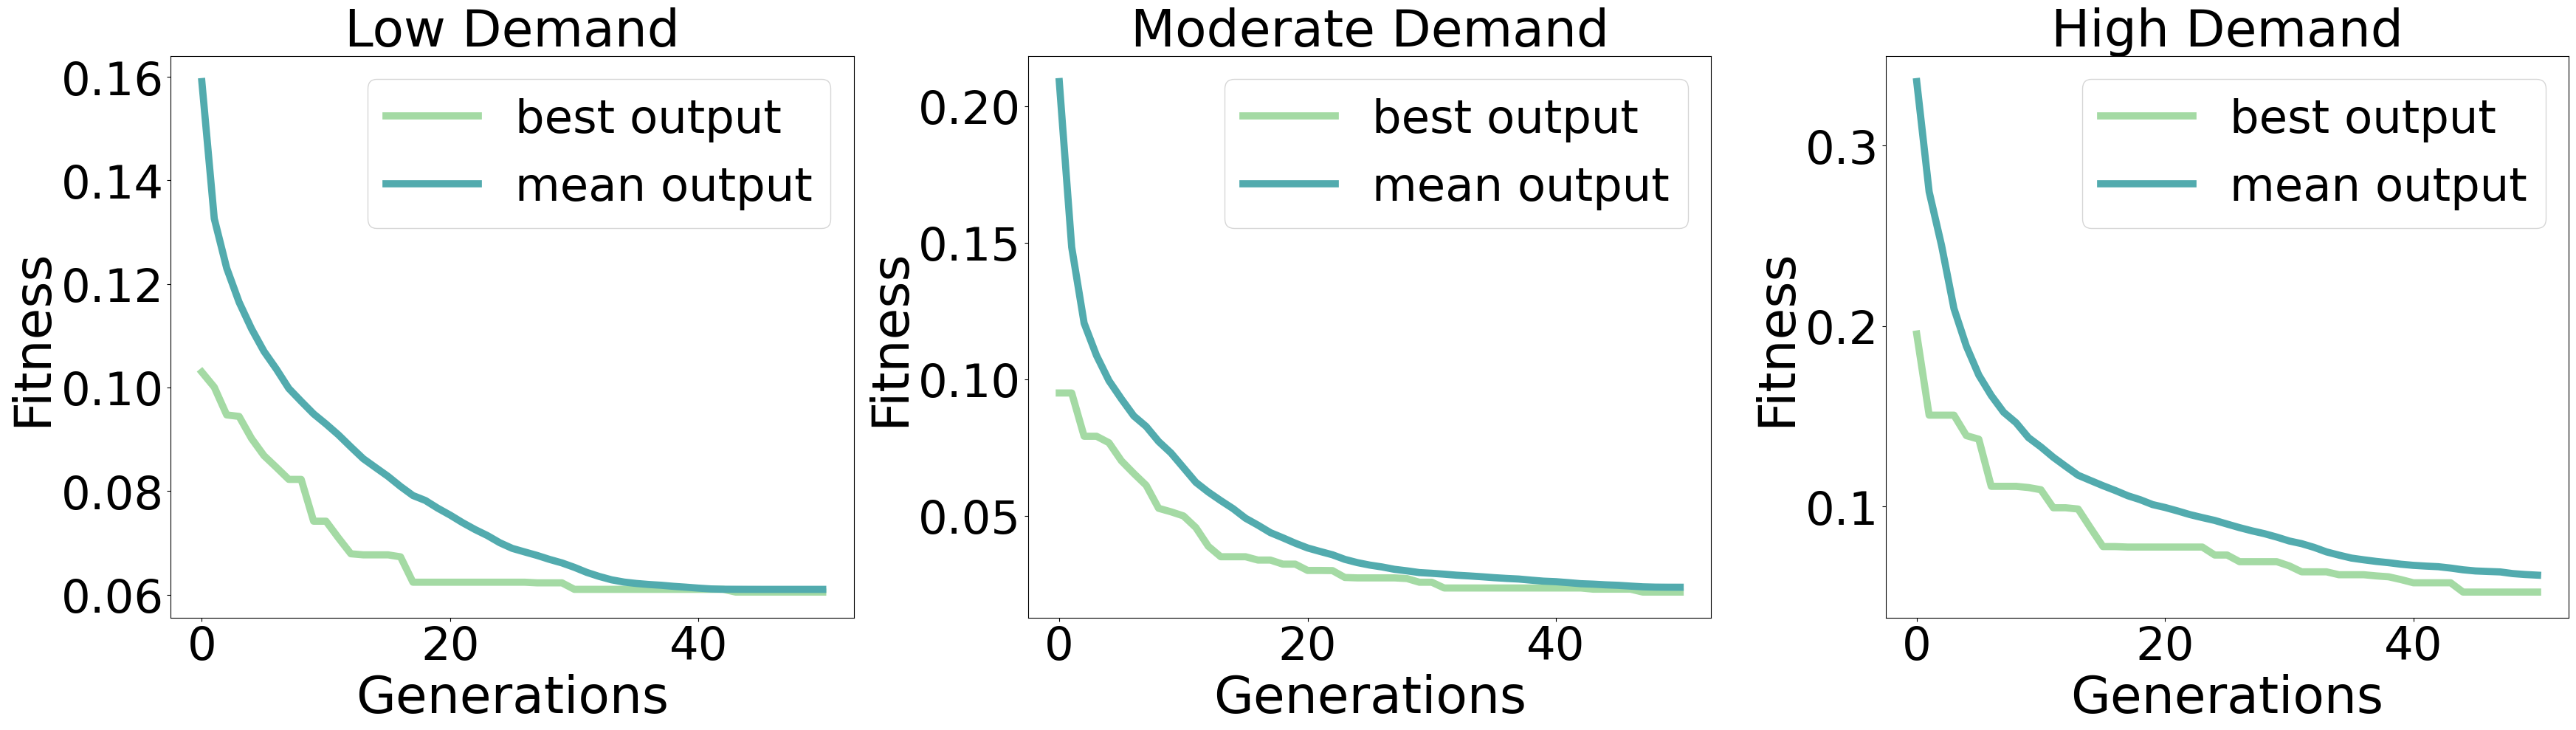

In [10]:
what = '2_trucks_Pc_0.8_Pm_0.01_thresh_stat_1_wu_0.5_wc_0.5_df_1'

num_rows = 1

num_cols = 3 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(35,10))  

for ind_ in range(len(['Low Demand','Moderate Demand','High Demand'])):
    i = ['Low Demand','Moderate Demand','High Demand'][ind_]
    if i=='Low Demand':
        hour = 420
    elif i=='Moderate Demand':
        hour = 615
    elif i=='High Demand':
        hour = 673
    row = ind_ // num_cols  
    col = ind_ % num_cols   
    ax = axes[ind_]       
    best = [np.absolute(float(j)) for j in dict_[what][(dict_[what]['mid_key']==hour)&(dict_[what]['Case']=='GA_predicted')&(dict_[what]['key']=='best_outputs')]['value'].to_list()]

    mean = [np.absolute(float(j)) for j in dict_[what][(dict_[what]['mid_key']==hour)&(dict_[what]['Case']=='GA_predicted')&(dict_[what]['key']=='mean_outputs')]['value'].to_list()]

    ax.plot(range(len(best)), best, lw=7,color=palette_colors[3],label='best output')
    ax.plot(range(len(mean)), mean, lw=7,color=palette_colors[2],label='mean output')        
    
    ax.set_title(i, fontsize=50)  
    
    ax.set_xlabel("Generations", fontsize=50)
    ax.set_ylabel("Fitness", fontsize=50)
    # ax.set_yscale('log') 
    ax.tick_params(axis='x', labelsize=45)  # Increase x-tick label size
    ax.tick_params(axis='y', labelsize=45)  # Increase y-tick label size
    ax.legend(loc='upper right', fontsize=45)
for i in range(len(['Low Demand','Moderate Demand','High Demand']), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
# plt.show()
plt.savefig('./plots/plots_analysis_3_fitness.png', dpi=100, bbox_inches='tight')
            

    

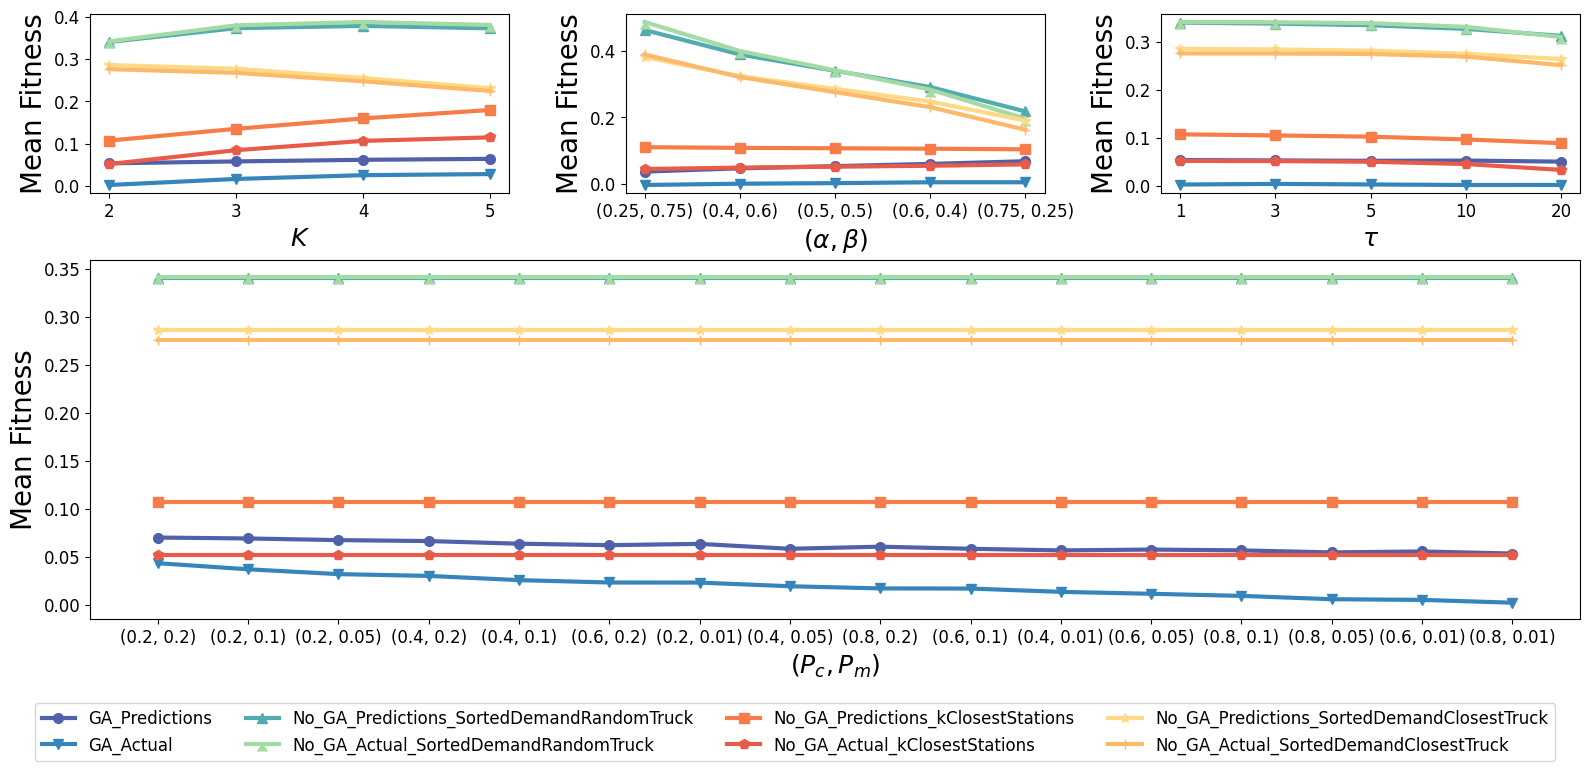

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

# Assuming whole_df and other necessary variables are defined

# Define the layout
fig = plt.figure(figsize=(16, 7))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2])  

markers = [ 'o', 'v', '^', 6, 's', 'p', '*', '+', 'x','|', '_']
mk=7
linew=3
xlabelsize=18
ylabelsize=20
xtickssize=12
ytickssize=12
titlesize=23
i = 0
ax = plt.subplot(gs[0, i])
# ... (plotting code for each subplot in the first row)
ticks = [2, 3, 4, 5]
df_1 = whole_df[(whole_df['truck']!=1)&(whole_df['Pc']==0.8)&(whole_df['Pm']==0.01)& (whole_df['wu']==0.5)&(whole_df['thresh_stat']==1)&(whole_df['Variable']=='fitness')].sort_values(['alg_number','Pc','Pm','truck'],ascending=(True, True,False, True))
for algo in range(len(algorithm_mapping.keys())):
    algorithm=list(algorithm_mapping.keys())[algo]
    ax.plot(range(len(df_1[df_1['Algorithm']==algorithm]['Value (mean)'].to_list())), df_1[df_1['Algorithm']==algorithm]['Value (mean)'].to_list(), lw=linew,color=color_dict[algorithm_mapping[algorithm]],label=algorithm_mapping[algorithm], marker=markers[algo],markersize=mk)
    ax.set_xlabel('$K$', fontsize=xlabelsize)
    ax.set_ylabel("Mean Fitness", fontsize=ylabelsize)
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks)
    ax.tick_params(axis='x', labelsize=xtickssize)  # Increase x-tick label size
    ax.tick_params(axis='y', labelsize=ytickssize)  # Increase y-tick label size



i = 1
ax = plt.subplot(gs[0, i])
# ... (plotting code for each subplot in the first row)
ticks = np.array(['(0.25, 0.75)', '(0.4, 0.6)', '(0.5, 0.5)', '(0.6, 0.4)', '(0.75, 0.25)'])
df_1 = whole_df[(whole_df['truck']==2)&(whole_df['Pc']==0.8)&(whole_df['Pm']==0.01)&(whole_df['thresh_stat']==1)&(whole_df['Variable']=='fitness')].sort_values(['alg_number','Pc','Pm','truck'],ascending=(True, True,False, True))
for algo in range(len(algorithm_mapping.keys())):
    algorithm=list(algorithm_mapping.keys())[algo]
    ax.plot(range(len(df_1[df_1['Algorithm']==algorithm]['Value (mean)'].to_list())), df_1[df_1['Algorithm']==algorithm]['Value (mean)'].to_list(), lw=linew,color=color_dict[algorithm_mapping[algorithm]],label=algorithm_mapping[algorithm], marker=markers[algo],markersize=mk)
    ax.set_xlabel(r'$({\alpha}, {\beta})$', fontsize=xlabelsize)
    ax.set_ylabel("Mean Fitness", fontsize=ylabelsize)
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks)
    ax.tick_params(axis='x', labelsize=xtickssize)  # Increase x-tick label size
    ax.tick_params(axis='y', labelsize=ytickssize)  # Increase y-tick label size


i = 2
ax = plt.subplot(gs[0, i])
# ... (plotting code for each subplot in the first row)
ticks = [1, 3, 5, 10, 20]
df_1 = whole_df[(whole_df['truck']==2)&(whole_df['Pc']==0.8)&(whole_df['Pm']==0.01)&(whole_df['wu']==0.5)&(whole_df['Variable']=='fitness')].sort_values(['alg_number','Pc','Pm','truck'],ascending=(True, True,False, True))
for algo in range(len(algorithm_mapping.keys())):
    algorithm=list(algorithm_mapping.keys())[algo]
    ax.plot(range(len(df_1[df_1['Algorithm']==algorithm]['Value (mean)'].to_list())), df_1[df_1['Algorithm']==algorithm]['Value (mean)'].to_list(), lw=linew,color=color_dict[algorithm_mapping[algorithm]],label=algorithm_mapping[algorithm], marker=markers[algo],markersize=mk)
    ax.set_xlabel(r'$\tau$', fontsize=xlabelsize)
    ax.set_ylabel("Mean Fitness", fontsize=ylabelsize)
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks)
    ax.tick_params(axis='x', labelsize=xtickssize)  # Increase x-tick label size
    ax.tick_params(axis='y', labelsize=ytickssize)  # Increase y-tick label size

# Second row plot (one plot spanning the entire width)
ax2 = plt.subplot(gs[1, :])
# ... (plotting code for the large subplot in the second row)
ticks = np.array([str((i,j))  for i in [0.2, 0.4, 0.6, 0.8] for j in [0.2, 0.1, 0.05, 0.01]])

df_1 = whole_df[(whole_df['truck']==2)&(whole_df['wu']==0.5)&(whole_df['thresh_stat']==1)&(whole_df['Variable']=='fitness')].sort_values(['alg_number','Pc','Pm','truck'],ascending=(True, True,False, True))
# Create a new ordered dictionary

val = df_1[df_1['Algorithm']=='GA_actual']['Value (mean)'].to_list()
key  = [f'({a}, {b})' for a, b in zip(df_1[df_1['Algorithm']=='GA_actual']['Pc'].to_list(), df_1[df_1['Algorithm']=='GA_actual']['Pm'].to_list())]
my_dict = {key: value for key, value in zip(key, val)}
sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))
ticks = list(sorted_dict.keys())
for algo in range(len(algorithm_mapping.keys())):
    algorithm=list(algorithm_mapping.keys())[algo]

    val = df_1[df_1['Algorithm']==algorithm]['Value (mean)'].to_list()
    key  = [f'({a}, {b})' for a, b in zip(df_1[df_1['Algorithm']==algorithm]['Pc'].to_list(), df_1[df_1['Algorithm']==algorithm]['Pm'].to_list())]
    my_dict = {key: value for key, value in zip(key, val)}
    ordered_dict = {key: my_dict[key] for key in ticks if key in my_dict}
    vals=list(ordered_dict.values())
    if algorithm not in ['GA_predicted','GA_actual']:
        vals=[vals[0] for i in range(len(vals))]
    ax2.plot(range(len(ticks)), vals, lw=linew,color=color_dict[algorithm_mapping[algorithm]],label=algorithm_mapping[algorithm], marker=markers[algo],markersize=mk)
    # ax2.set_title('Role of Pc and Pm', fontsize=titlesize)  
    ax2.set_xlabel('$(P_c, P_m)$', fontsize=xlabelsize)
    ax2.set_ylabel("Mean Fitness", fontsize=ylabelsize)
    # ax.set_yscale('log') 
    ax2.set_xticks(range(len(ticks)))
    ax2.set_xticklabels(ticks)
    ax2.tick_params(axis='x', labelsize=xtickssize)  # Increase x-tick label size
    ax2.tick_params(axis='y', labelsize=ytickssize)  # Increase y-tick label size



# Now, create a single legend for the whole figure below the subplots
handles, labels = [], []
for ax in fig.axes:
    new_handles, new_labels = ax.get_legend_handles_labels()
    handles.extend(new_handles)
    labels.extend(new_labels)

# Deduplicate handles/labels
unique_handles_labels = dict(zip(labels, handles)).items()
unique_labels, unique_handles = zip(*unique_handles_labels)

# Create the legend with the collected handles and labels
fig.legend(unique_handles, unique_labels, bbox_to_anchor=(0.5, 0), loc='upper center', fontsize=12, ncol=4)


plt.tight_layout()
plt.subplots_adjust(hspace=0.25) 

# plt.show()
plt.savefig('./plots/plots_analysis_4_fitness.png', dpi=100, bbox_inches='tight')
            

